# Acknowledgement
Thanks to **Yuval Fernbach** for posting the code here:
https://github.com/yuvalfer/mxnet-notebooks/blob/master/linear_learner_mnist_fraud/linear_learner_mnist-CreditCard.ipynb

# Part 1: Preprocessing data
If you are intersted in learning about preprocessing data, you should start here, otherwise you could simply start from part 2, when we load the data from npy files.

In [53]:
#imports
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import sagemaker.amazon.common as smac
import os
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

In [31]:
bucket = 'cyrusmv-sagemaker-demos'     #replace this with your own bucket 
prefix = 'visa-kaggle/original.csv'    #replace this with your own file inside the bucket
protocol="s3://"
datafile = 'data/original.csv'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

arn:aws:iam::475933981307:role/service-role/AmazonSageMaker-ExecutionRole-20180102T172706


### Data ingestion
1. Downloding file locally
2. Loading file into pandas for inspection
3. conversting data to numpy
4. shuffling the data
5. spliting data into test and training
6. breaking up each data set to data and label

In [32]:
#Downloading the file to a local folder
client = boto3.client('s3')
with open(datafile, 'wb') as f:
    client.download_fileobj(bucket, prefix, f)

In [33]:
# loading data into pandas for inspection

df = pd.read_csv(datafile)
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [34]:
df['Class'].count()

284807

In [35]:
df[df['Class'] == 1]['Class'].count()

492

In [36]:
#Converting Data Into Numpy

raw_data = df.as_matrix()
print(raw_data.shape)

(284807, 31)


In [37]:
#Shuffling the data
np.random.seed(123)
np.random.shuffle(raw_data)
label = raw_data[:, -1]
data = raw_data[:, :-1]


In [38]:
print("label_shape = {}; data_shape= {}".format(label.shape, data.shape))

label_shape = (284807,); data_shape= (284807, 30)


In [39]:
# There are very few fraudulant transactions in the dataset, so I am putting their indexes in an array
# to plot and ensure they are evenly distributed, so when I split the dataset into test and training 
# I don't end up with a dispropostionate distribution
t = []
for i in range(len(label)):
    if label[i] == 1:
        t.append(i)

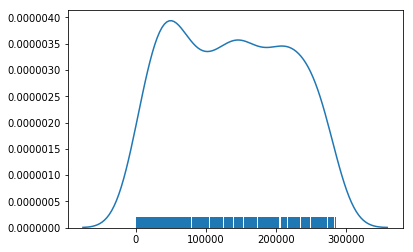

In [40]:
sns.distplot(t, kde=True, rug=True, hist=False)
plt.show()

In [100]:
#Splitting data into validation and training and breaking dataset into data and label

#60%-40% training to validation
train_size = int(data.shape[0]*0.6)

train_data  = data[:train_size, :]
val_data = data[train_size:, :]

train_label = label[:train_size]
val_label = label[train_size:]

#Saving arrays for later use
np.save('data/train_data.npy', train_data, allow_pickle=True)
np.save('data/train_label.npy', train_label, allow_pickle=True)
np.save('data/val_data.npy', val_data, allow_pickle=True)
np.save('data/val_label.npy', val_label, allow_pickle=True)


print("training data shape= {}; training label shape = {} \nValidation data shape= {}; validation label shape = {}".format(train_data.shape, 
                                                                        train_label.shape,
                                                                        val_data.shape,
                                                                        val_label.shape))




training data shape= (170884, 30); training label shape = (170884,) 
Validation data shape= (113923, 30); validation label shape = (113923,)


# Part 2: Training
In this part we load the data from pre-processed files and train the model.

In [101]:
train_data = np.load('data/train_data.npy')
train_label = np.load('data/train_label.npy')

val_data = np.load('data/val_data.npy')
val_label = np.load('data/val_label.npy')

print("training data shape= {}; training label shape = {} \nValidation data shape= {}; validation label shape = {}".format(train_data.shape, 
                                                                        train_label.shape,
                                                                        val_data.shape,
                                                                        val_label.shape))
train_set = (train_data, train_label)
test_set = (val_data, val_label)


training data shape= (170884, 30); training label shape = (170884,) 
Validation data shape= (113923, 30); validation label shape = (113923,)


# Data Conversion
Amazon Algorithms support csv and recordio/protobuf. recordio is faster than CSV and specially in algorithms that deal with sparse matrices, CSV is not supported, so I just convert the data into recordio

In [102]:
vectors = np.array([t.tolist() for t in train_set[0]]).astype('float32')
labels = np.array([t.tolist() for t in train_set[1]]).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

# Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [103]:
key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://cyrusmv-sagemaker-demos/visa-kaggle/original.csv/train/recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [104]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://cyrusmv-sagemaker-demos/visa-kaggle/original.csv/output


# Training the model
At this point we are using an linear learner from amazon algorithms. Docker file containing the model is located in multiple regions. We tool the following steps
1. define containers
2. Create am Estimator object and pass the hyper-parameters as well as the model location to it.
3. run Estimator.fit to begin training the model

In [52]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}

In [54]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, #S3 role, so the notebook can read the data and upload the model
                                       train_instance_count=1, #number of instances for training
                                       train_instance_type='ml.p2.xlarge', # type of training instance
                                       output_path=output_location, #s3 location for uploading trained mdoel
                                       sagemaker_session=sess)

linear.set_hyperparameters(feature_dim=30, #dataset has 30 columns (features)
                           predictor_type='binary_classifier', # we predict a binary value. it could have been regressor
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-01-03-11-49-37-675


.................................................................................
Arguments: train
[01/03/2018 11:56:17 INFO 140429112674112 integration.py:222] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', u'target_recall': u'0.8', u'num_models': u'32', u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_classifier_model_selection_criteria': u'accuracy', u'use_lr_scheduler': u'true', u'target_precision': u'0.8', u'force_dense': u'true', u'unbias_

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.006213935302696965, "sum": 0.006213935302696965, "min": 0.006213935302696965}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980647.68726, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1514980647.686962}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.005266643648386978, "sum": 0.005266643648386978, "min": 0.005266643648386978}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980647.687359, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1514980647.687342}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0053234232543363505, "sum": 0.0053234232543363505, "min": 0.0053234232543363505}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980680.974272, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1514980680.974148}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004676577107636236, "sum": 0.004676577107636236, "min": 0.004676577107636236}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980680.974373, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1514980680.974356}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.005038821134864586, "sum": 0.005038821134864586, "min": 0.005038821134864586}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980714.288892, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1514980714.288779}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004552188813904479, "sum": 0.004552188813904479, "min": 0.004552188813904479}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980714.289005, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1514980714.288981}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004915164299047523, "sum": 0.004915164299047523, "min": 0.004915164299047523}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980747.652135, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1514980747.651718}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004478250153066124, "sum": 0.004478250153066124, "min": 0.004478250153066124}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980747.652246, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1514980747.652222}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004854489116901117, "sum": 0.004854489116901117, "min": 0.004854489116901117}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980780.974051, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1514980780.973911}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004425792935363233, "sum": 0.004425792935363233, "min": 0.004425792935363233}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980780.974151, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1514980780.974133}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004822987571655308, "sum": 0.004822987571655308, "min": 0.004822987571655308}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980814.182285, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1514980814.182158}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004405417282099397, "sum": 0.004405417282099397, "min": 0.004405417282099397}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980814.182386, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1514980814.182369}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.00480559869204807, "sum": 0.00480559869204807, "min": 0.00480559869204807}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980847.339132, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1514980847.338955}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004385153301958806, "sum": 0.004385153301958806, "min": 0.004385153301958806}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980847.339271, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1514980847.339247}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, 

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004790482024293594, "sum": 0.004790482024293594, "min": 0.004790482024293594}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980880.938624, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1514980880.938508}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.0043723995594931574, "sum": 0.0043723995594931574, "min": 0.0043723995594931574}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980880.938726, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1514980880.938709}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.004773788956065926, "sum": 0.004773788956065926, "min": 0.004773788956065926}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980914.17032, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1514980914.170188}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "max": 0.00434559062655483, "sum": 0.00434559062655483, "min": 0.00434559062655483}, "validation_binary_classification_cross_entropy": {"count": 1, "max": -Infinity, "sum": NaN, "min": Infinity}}, "EndTime": 1514980914.170416, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1514980914.1704}

#metrics {"Metrics": {"training_binary_classification_cross_entropy": {"count": 1, "

#metrics {"Metrics": {"f1": {"count": 1, "max": 0.8019966722129783, "sum": 0.8019966722129783, "min": 0.8019966722129783}, "threshold_for_accuracy": {"count": 1, "max": 0.1104748472571373, "sum": 0.1104748472571373, "min": 0.1104748472571373}, "threshold_for_precision_at_target_recall": {"count": 1, "max": 0.045947615057229996, "sum": 0.045947615057229996, "min": 0.045947615057229996}, "threshold_for_recall_at_target_precision": {"count": 1, "max": 0.09909462928771973, "sum": 0.09909462928771973, "min": 0.09909462928771973}, "recall_at_precision": {"count": 1, "max": 0.7838709677420052, "sum": 0.7838709677420052, "min": 0.7838709677420052}, "precision_at_target_recall": {"count": 1, "max": 0.7781155015198242, "sum": 0.7781155015198242, "min": 0.7781155015198242}, "accuracy": {"count": 1, "max": 0.9993036211699164, "sum": 0.9993036211699164, "min": 0.9993036211699164}, "threshold_for_f1": {"count": 1, "max": 0.1104748472571373, "sum": 0.1104748472571373, "min": 0.1104748472571373}}, "En

===== Job Complete =====


# Hosting the model
We use sagemaker to host the live model by calling deploy from estimator we defined previously. This action will create a dockerized environment using ECS and permits autoscaling. 

In [56]:
linear_predictor = linear.deploy(initial_instance_count=1, #Initial number of instances. 
                                                           #Autoscaling can increase the number of instances.
                                 instance_type='ml.m4.xlarge') # instance type

INFO:sagemaker:Creating model with name: linear-learner-2018-01-03-12-16-51-271
INFO:sagemaker:Creating endpoint with name linear-learner-2018-01-03-11-49-37-675


ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:eu-west-1:475933981307:endpoint/linear-learner-2018-01-03-11-49-37-675".

# Prediction
deploy resturn a live endpoint (linear_predictor). Predictors in sagemaker accept csv and json. In this case we use json serialization.

In [105]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [107]:
#since score==1 is very rare we want to make sure we can correctly predict fradulant transaction. 
#First we print a lost of all labels where score == 1, then then run a prediction
t = []
for i in range(len(train_label)):
    if train_label[i] == 1:
        t.append(i)
        
print(t)
print(linear_predictor.predict(train_set[0][1294:1299]))


[48, 278, 921, 1240, 1295, 1348, 2062, 3238, 3549, 4307, 6305, 6887, 7448, 7558, 7697, 7729, 7752, 9658, 10297, 12178, 13015, 13940, 14306, 15025, 15378, 15843, 15939, 17018, 17454, 17575, 17786, 18699, 19021, 19265, 19306, 19642, 19774, 21181, 21257, 21491, 22530, 24068, 24983, 25715, 25779, 25957, 26155, 27148, 27506, 27832, 28158, 28801, 29014, 29699, 31210, 31237, 31495, 31730, 32247, 32613, 32696, 32787, 33422, 33624, 33651, 34621, 35158, 35159, 35566, 36301, 36634, 37604, 39394, 39840, 40911, 41554, 41799, 41814, 42431, 43028, 43616, 43651, 44184, 44498, 44852, 45296, 45476, 45619, 45887, 46043, 46782, 46938, 46950, 47970, 47977, 48477, 49048, 49207, 49464, 49847, 50313, 50494, 51579, 51689, 52417, 53386, 53440, 53730, 54483, 55461, 55614, 56397, 56452, 56882, 56955, 57901, 57922, 58898, 58902, 58964, 59764, 59847, 61109, 61286, 61833, 62215, 62234, 62595, 63274, 63471, 63768, 64214, 64611, 65408, 66051, 66627, 66720, 66887, 67065, 67573, 67672, 67681, 69141, 69143, 69224, 69519,

In [117]:
non_zero = np.count_nonzero(test_set[1])
zero = len(test_set[1]) - non_zero
print("validation set includes: {} non zero and {} items woth value zero".format(non_zero, zero))

validation set includes: 182 non zero and 113741 items woth value zero


In [108]:
predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [109]:
import pandas as pd

pd.crosstab(test_set[1], predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0.0,113722,19
1.0,39,143


The confusion matrix above indicates that:
- of 162 fraudulant cases we detected 143 correcly
- 39 times a non-fraudulant transaction has been flagges as fraud from a total of 113761 transactions.


# (optional) Delete the endpoint
f you're ready to be done with this notebook, please run the delete_endpoint line in the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [121]:
#sagemaker.Session().delete_endpoint(linear_predictor.endpoint)